Electrode Segmentation
==============


References:
1. [Basics of Image Processing in Python](https://www.analyticsvidhya.com/blog/2014/12/image-processing-python-basics/) //detecting stars
2. [Blob Detection Techniques](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html)

Compare and Contrast different Blob detection techniques [2]
    Blob Detection
    Blobs are bright on dark or dark on bright regions in an image. In this example, blobs are detected using 3 algorithms. The image used in this case is the Hubble eXtreme Deep Field. Each bright dot in the image is a star or a galaxy.

    Laplacian of Gaussian (LoG)
    This is the most accurate and slowest approach. It computes the Laplacian of Gaussian images with successively increasing standard deviation and stacks them up in a cube. Blobs are local maximas in this cube. Detecting larger blobs is especially slower because of larger kernel sizes during convolution. Only bright blobs on dark backgrounds are detected. See skimage.feature.blob_log() for usage.

    Difference of Gaussian (DoG)
    This is a faster approximation of LoG approach. In this case the image is blurred with increasing standard deviations and the difference between two successively blurred images are stacked up in a cube. This method suffers from the same disadvantage as LoG approach for detecting larger blobs. Blobs are again assumed to be bright on dark. See skimage.feature.blob_dog() for usage.

    Determinant of Hessian (DoH)
    This is the fastest approach. It detects blobs by finding maximas in the matrix of the Determinant of Hessian of the image. The detection speed is independent of the size of blobs as internally the implementation uses box filters instead of convolutions. Bright on dark as well as dark on bright blobs are detected. The downside is that small blobs (<3px) are not detected accurately. See skimage.feature.blob_doh() for usage.

In [1]:
# %load headers_files.py
import os
import sys
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import importlib
import cv2 as cv

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter, circle
from skimage.util import img_as_ubyte
from skimage import feature
from scipy import ndimage as ndi 

- find maxima with tolerance of 24

In [2]:
from circle_mask import circleMask, preprocess_exterior
#from auto_thresholding import auto_median_canny, auto_otsu_canny 
import myfunctions 
#import validate
import electrode_detection1
import linear_regression
#from custom_canny import electrode_detection2
#from custom_canny import electrode_detection3
#import electrode_detection1

/home/ruiqi/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#generate pixels
raw_patient = np.array(['Data/fluoro_subject_1c.tif',
                        'Data/fluoro_subject_2b.tif',
                        'Data/fluoro_subject_3.tif',
                        'Data/fluoro_subject_4.tif', #trouble
                        'Data/fluoro_subject_5.tif',
                        'Data/DBS_bG02_fluoro.tif',  #trouble
                        'Data/DBS_bG03_fluoro.tif',
                        'Data/DBS_bG06_fluoro.tif',
                        'Data/DBS_bG09_fluoro.tif',
                        'Data/DBS_bG10_fluoro.tif',
                        'Data/DBS_bG12_fluoro.tif',
                        'Data/DBS_bG13_fluoro.tif',
                        'Data/DBS_bG17_fluoro.tif',
                        'Data/DBS_bG18_fluoro.tif',
                        'Data/DBS_bG19_fluoro.tif'
                       ])

save_path = np.array([  'Data/patient_0.npy', #great!, can fix! 
                        'Data/patient_1.npy', #great!
                        'Data/patient_2.npy', #great!
                        'Data/patient_3.npy', #difficult to pick up, subject_4
                        'Data/patient_4.npy', #great!
                        'Data/patient_5.npy', #trouble
                        'Data/patient_6.npy', #trouble, don't pick up in the blob
                        'Data/patient_7.npy', #ok, not perfect 
                        'Data/patient_8.npy', #great!
                        'Data/patient_9.npy', #great, but missing right end points 
                        'Data/patient_10.npy', #great, but missing left end points (more than 5) 
                        'Data/patient_11.npy', #ok with 2 (lots of noise), awesome with 3
                        'Data/patient_12.npy', # awesome 2
                        'Data/patient_13.npy', # awesome 2
                        'Data/patient_14.npy'  #awesome 2
                     ])
"""
labeled_path = np.array(['Data/Real_label_position/label_elect_patient0.npy', #great!, can fix! 
                        'Data/Real_label_position/label_elect_patient1.npy', #great!
                        'Data/Real_label_position/label_elect_patient2.npy', #great!
                        'Data/Real_label_position/label_elect_patient3.npy', #difficult to pick up, subject_4
                        'Data/Real_label_position/label_elect_patient4.npy', #great!
                        'Data/Real_label_position/label_elect_patient5.npy', #trouble
                        'Data/Real_label_position/label_elect_patient6.npy', #trouble, don't pick up in the blob
                        'Data/Real_label_position/label_elect_patient7.npy', #ok, not perfect 
                        'Data/Real_label_position/label_elect_patient8.npy', #great!
                        'Data/Real_label_position/label_elect_patient9.npy', #great, but missing right end points 
                        'Data/Real_label_position/label_elect_patient10.npy', #great, but missing left end points (more than 5) 
                        'Data/Real_label_position/label_elect_patient11.npy', #ok with 2 (lots of noise), awesome with 3
                        'Data/Real_label_position/label_elect_patient12.npy', # awesome 2
                        'Data/Real_label_position/label_elect_patient13.npy', # awesome 2
                        'Data/Real_label_position/label_elect_patient14.npy'  #awesome 2
                     ])
"""

"\nlabeled_path = np.array(['Data/Real_label_position/label_elect_patient0.npy', #great!, can fix! \n                        'Data/Real_label_position/label_elect_patient1.npy', #great!\n                        'Data/Real_label_position/label_elect_patient2.npy', #great!\n                        'Data/Real_label_position/label_elect_patient3.npy', #difficult to pick up, subject_4\n                        'Data/Real_label_position/label_elect_patient4.npy', #great!\n                        'Data/Real_label_position/label_elect_patient5.npy', #trouble\n                        'Data/Real_label_position/label_elect_patient6.npy', #trouble, don't pick up in the blob\n                        'Data/Real_label_position/label_elect_patient7.npy', #ok, not perfect \n                        'Data/Real_label_position/label_elect_patient8.npy', #great!\n                        'Data/Real_label_position/label_elect_patient9.npy', #great, but missing right end points \n                        'Data/R

This is the official line!
=============================

In [7]:
import importlib

importlib.reload(linear_regression)
importlib.reload(electrode_detection1)

<module 'electrode_detection1' from '/home/ruiqi/BE 227/testing/electrode_detection1.py'>

electrode_results for  Data/fluoro_subject_1c.tif
big_radius =  367
big_central_coordinate =  (368, 576)


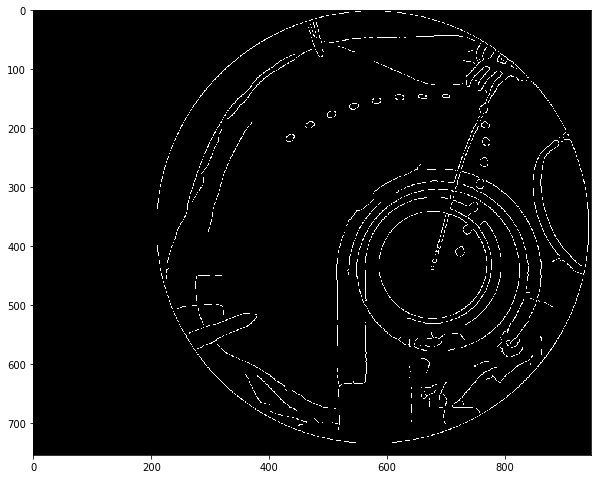

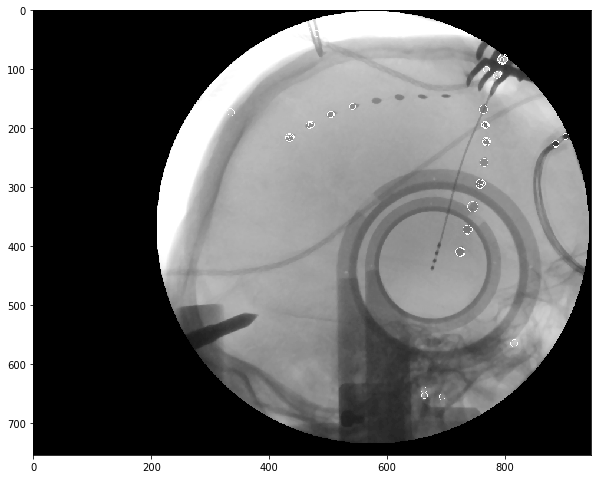

slope is  -1.848545156675435
intercept is  1699.6477932184225
r squared is  0.34780839014740816
r_squared :  0.34780839014740816
slope is  -0.2905201163329119
intercept is  303.9396536026263
r squared is  0.05328228208085566
r_squared :  0.05328228208085566
good cluster: 
 [[258 765]
 [168 764]
 [295 758]
 [194 766]
 [227 886]
 [223 769]
 [214 904]
 [224 769]
 [410 724]
 [222 768]
 [226 887]
 [100 769]
 [294 759]
 [565 816]
 [372 736]
 [195 767]
 [372 737]
 [410 725]
 [ 82 797]
 [195 769]
 [654 664]
 [ 84 793]
 [292 759]
 [ 84 799]
 [110 787]
 [108 790]
 [656 694]
 [644 663]
 [291 760]
 [225 770]
 [333 746]
 [ 84 796]]


/home/ruiqi/.local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


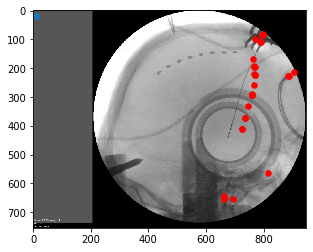

electrode_results for  Data/fluoro_subject_2b.tif
big_radius =  496
big_central_coordinate =  (500, 780)


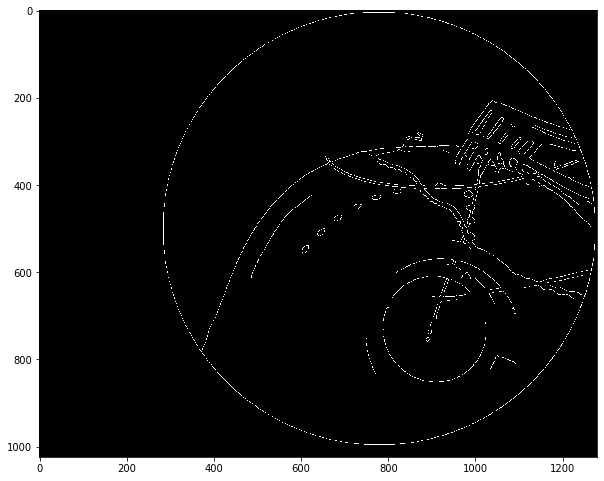

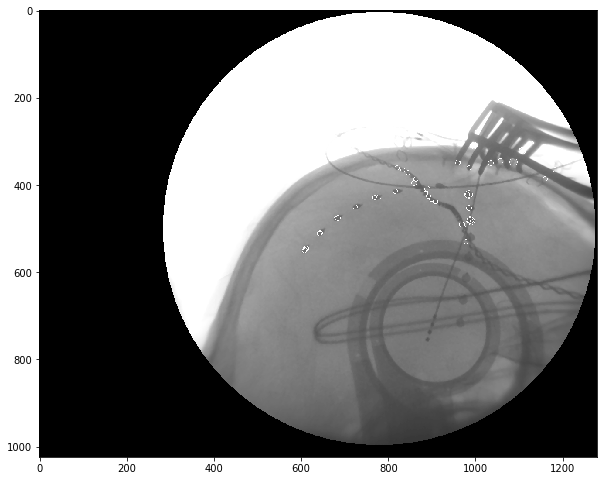

slope is  -0.46965458352162304
intercept is  809.4808572094255
r squared is  0.728106466166939
r_squared :  0.728106466166939
slope is  -0.5237309586481953
intercept is  935.018654144006
r squared is  0.22683146170454563
r_squared :  0.22683146170454563
good cluster: 
 [[512 643]
 [478 681]
 [415 817]
 [550 609]
 [511 644]
 [551 608]
 [451 725]
 [429 770]
 [426 893]
 [420 886]
 [476 685]
 [361 821]
 [366 834]
 [428 779]
 [433 900]
 [438 909]
 [387 864]
 [409 890]
 [546 612]
 [396 860]
 [372 846]]


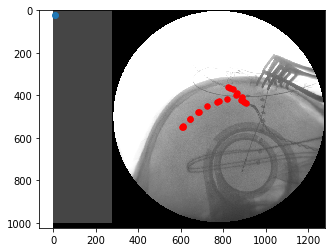

electrode_results for  Data/fluoro_subject_3.tif
big_radius =  496
big_central_coordinate =  (500, 780)


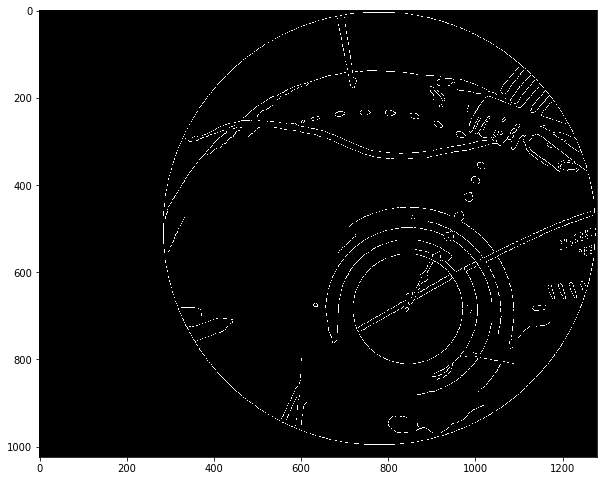

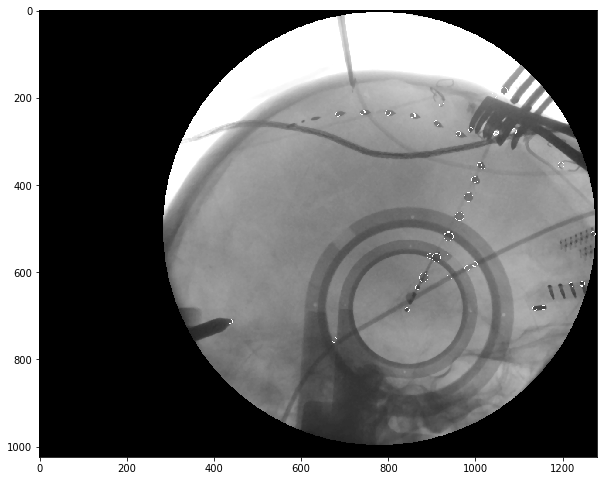

slope is  0.18712691539381257
intercept is  98.94011318152806
r squared is  0.14987490133260234
r_squared :  0.14987490133260234
slope is  -0.09106161747228672
intercept is  699.1831994536291
r squared is  0.06277667243832999
r_squared :  0.06277667243832999
good cluster: 
 [[ 428  985]
 [ 283 1047]
 [ 276 1090]
 [ 241  856]
 [ 283  961]
 [ 238  685]
 [ 234  741]
 [ 235  800]
 [ 184 1066]
 [ 284  962]
 [ 262  916]
 [ 259  911]
 [ 234  742]
 [ 217  923]
 [ 280 1049]
 [ 359 1018]
 [ 354 1010]
 [ 355 1197]
 [ 388  999]
 [ 277 1090]
 [ 241  857]
 [ 195 1044]
 [ 274  990]]


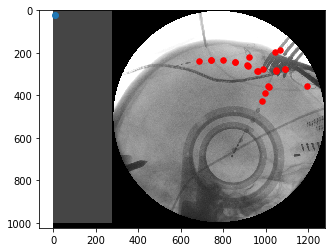

electrode_results for  Data/fluoro_subject_4.tif
big_radius =  496
big_central_coordinate =  (500, 780)


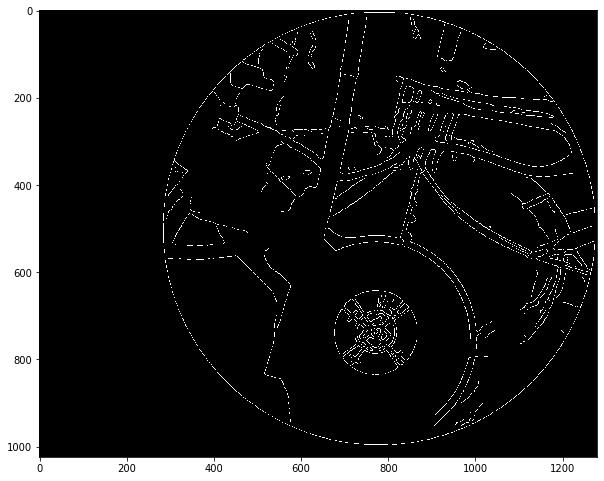

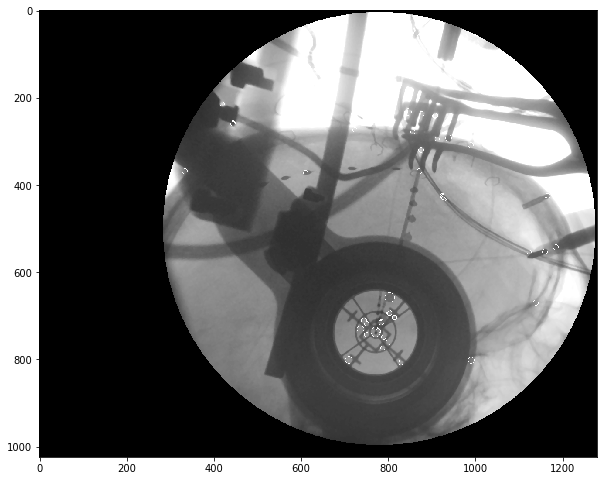

slope is  0.21367319372821433
intercept is  570.3353851001718
r squared is  0.08137496062675662
r_squared :  0.08137496062675662
slope is  0.29455658859113154
intercept is  93.63286041082284
r squared is  0.2864393263071934
r_squared :  0.2864393263071934
good cluster: 
 [[ 425 1167]
 [ 553 1160]
 [ 543 1185]
 [ 238  877]
 [ 554 1124]
 [ 241  909]
 [ 215  420]
 [ 293  939]
 [ 309  990]
 [ 372  611]
 [ 274  724]
 [ 279  857]
 [ 295  913]
 [ 260  444]
 [ 428  927]
 [ 426 1166]
 [ 320  876]
 [ 233  846]
 [ 426  925]
 [ 369  872]
 [ 259  444]
 [ 242  908]
 [  53  865]
 [ 431  929]
 [ 670 1139]
 [ 369  334]]


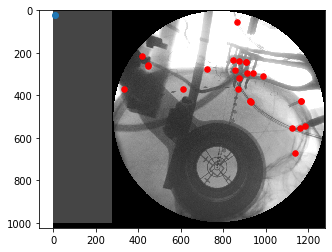

electrode_results for  Data/fluoro_subject_5.tif
big_radius =  496
big_central_coordinate =  (500, 780)


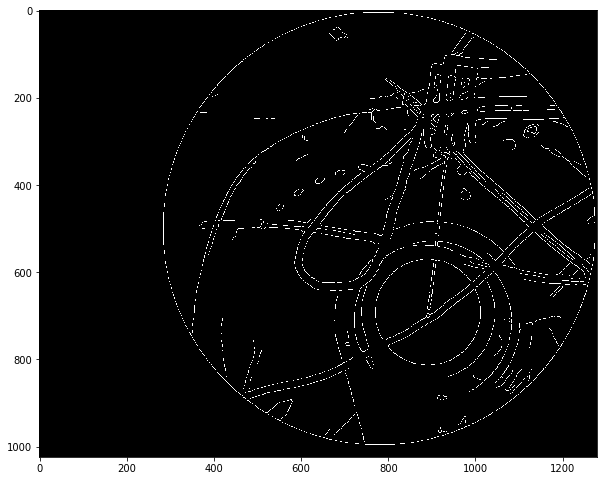

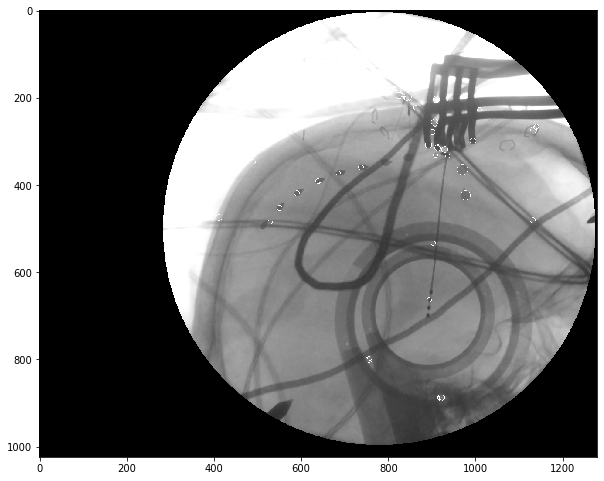

slope is  0.7003426520884521
intercept is  55.133728616996564
r squared is  0.35646351563391643
r_squared :  0.35646351563391643
slope is  0.3238715793389372
intercept is  -38.806980518506464
r squared is  0.2011525769315233
r_squared :  0.2011525769315233
good cluster: 
 [[424 978]
 [392 639]
 [360 738]
 [887 919]
 [485 530]
 [347 491]
 [887 924]
 [392 640]
 [797 758]
 [373 686]
 [534 904]
 [663 895]
 [475 412]
 [800 757]
 [888 922]
 [419 591]
 [453 551]]


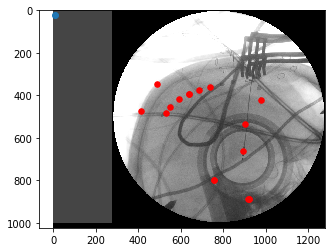

electrode_results for  Data/DBS_bG02_fluoro.tif
big_radius =  496
big_central_coordinate =  (500, 780)


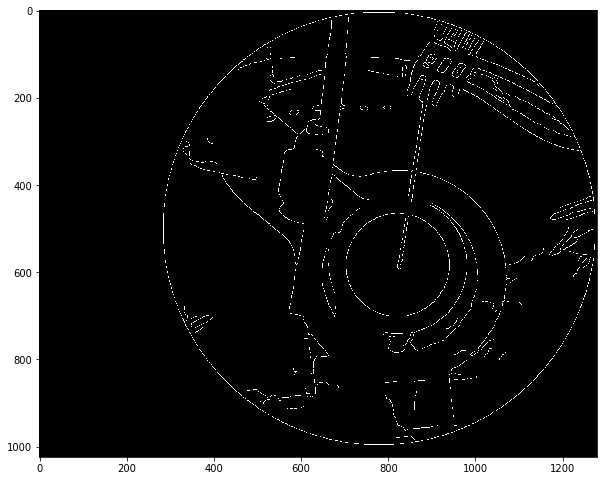

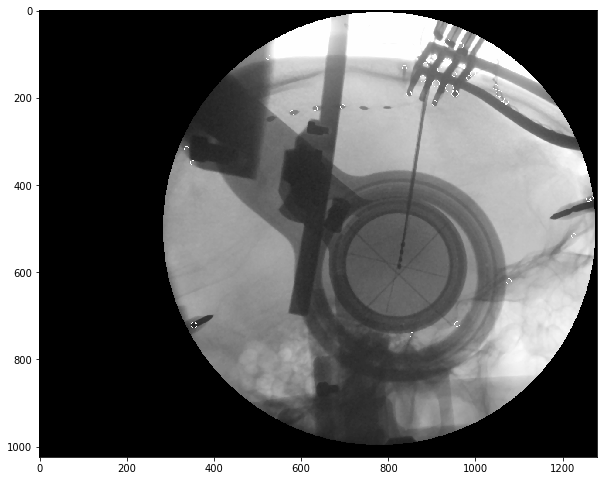

slope is  -0.6103876025106116
intercept is  674.4375079369297
r squared is  0.5755763271303018
r_squared :  0.5755763271303018
slope is  0.5686282573827517
intercept is  -326.20317150408357
r squared is  0.08577866485928273
r_squared :  0.08577866485928273
good cluster: 
 [[107 907]
 [125 886]
 [168 910]
 [114 894]
 [213 907]
 [721 355]
 [132 838]
 [107 908]
 [235 580]
 [192 849]
 [191 849]
 [722 354]
 [157 880]
 [108 525]
 [114 893]
 [225 633]
 [349 352]
 [317 338]
 [221 696]
 [136 920]]


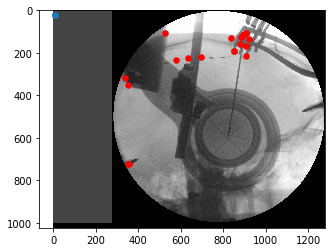

electrode_results for  Data/DBS_bG03_fluoro.tif
big_radius =  496
big_central_coordinate =  (500, 780)


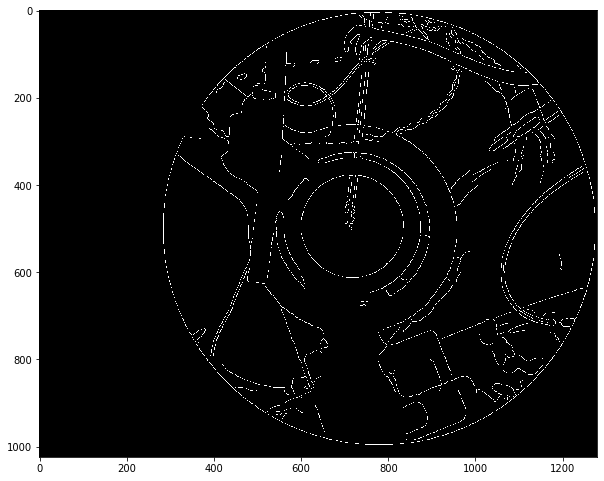

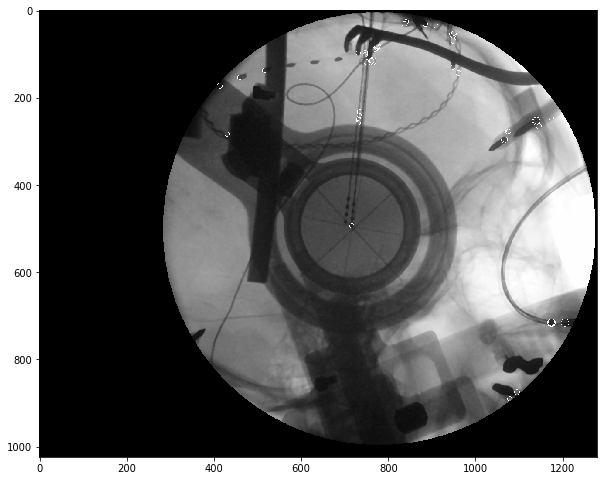

slope is  1.8934671580457305
intercept is  -1662.5895786759415
r squared is  0.5081641402162242
r_squared :  0.5081641402162242
slope is  -0.22754148036934987
intercept is  322.43601573971716
r squared is  0.07344233747788936
r_squared :  0.07344233747788936
good cluster: 
 [[ 716 1175]
 [ 254 1140]
 [  32  886]
 [ 297 1067]
 [ 715 1176]
 [  53  951]
 [ 890 1079]
 [ 296 1068]
 [ 875 1096]
 [  55  949]
 [ 278 1076]
 [ 277 1077]
 [ 247 1175]
 [ 131  949]
 [  36  910]
 [ 716 1206]
 [ 715 1174]
 [ 253 1141]
 [ 266 1146]
 [ 144  962]
 [  70  950]
 [  26  842]]


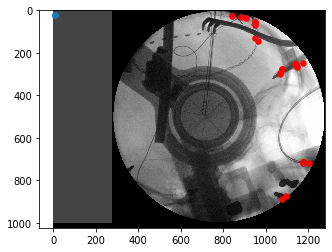

electrode_results for  Data/DBS_bG06_fluoro.tif
big_radius =  496
big_central_coordinate =  (500, 780)


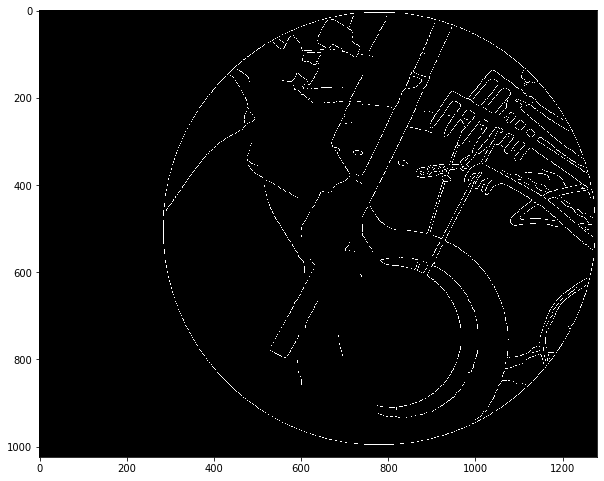

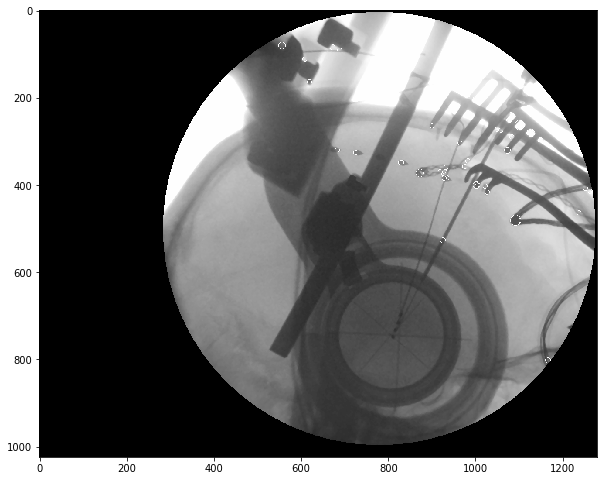

slope is  0.8278747176979481
intercept is  -625.6996922164499
r squared is  0.8080244436018583
r_squared :  0.8080244436018583
slope is  0.7878896891203204
intercept is  -353.9396972942164
r squared is  0.7152214614838986
r_squared :  0.7152214614838986
good cluster: 
 [[ 298 1150]
 [ 281 1128]
 [ 253 1078]
 [ 321 1074]
 [ 281 1126]
 [ 263 1102]
 [ 240 1083]
 [ 275 1059]
 [ 201  991]
 [ 290 1084]
 [ 464 1238]
 [ 282 1129]
 [ 252 1078]
 [ 408 1253]
 [ 415 1264]
 [ 273 1050]]


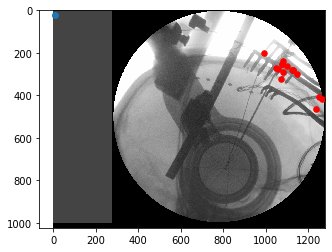

electrode_results for  Data/DBS_bG09_fluoro.tif
big_radius =  496
big_central_coordinate =  (500, 780)


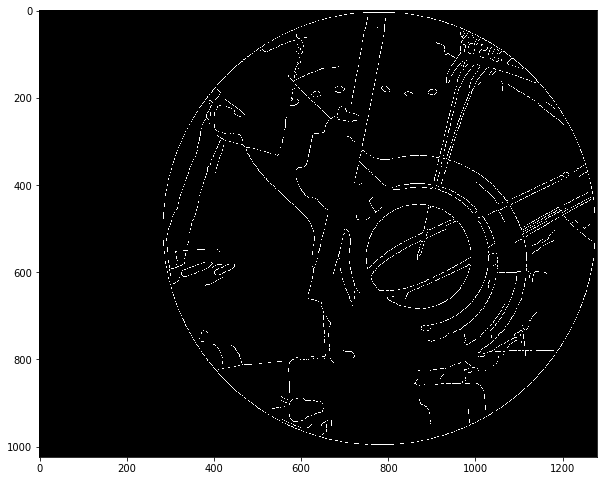

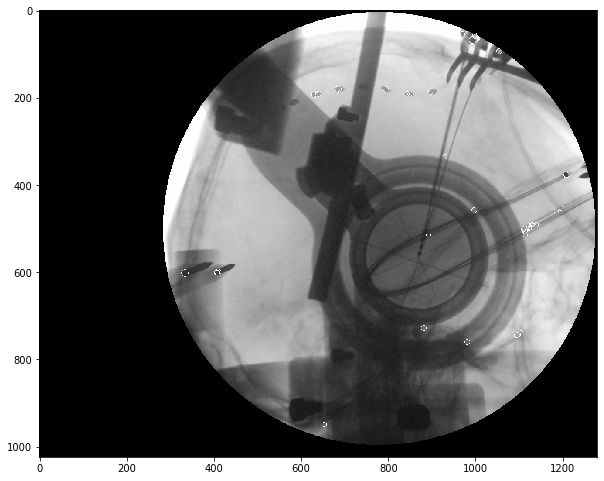

slope is  -0.7251030894564017
intercept is  1331.5478129184753
r squared is  0.4418411148436388
r_squared :  0.4418411148436388
slope is  -0.7344493045784783
intercept is  798.8368547793783
r squared is  0.759376318282696
r_squared :  0.759376318282696
good cluster: 
 [[ 336  931]
 [ 602  334]
 [ 601  408]
 [ 188  898]
 [ 600  410]
 [  58 1000]
 [  94 1055]
 [ 193  631]
 [  60 1000]
 [ 191  844]
 [ 192  850]
 [ 181  686]
 [ 193  633]
 [  68  994]
 [ 181  795]
 [ 192  640]
 [ 181  684]
 [  64 1006]
 [  54  971]
 [ 601  407]]


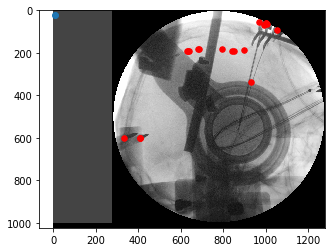

electrode_results for  Data/DBS_bG10_fluoro.tif
big_radius =  496
big_central_coordinate =  (500, 780)


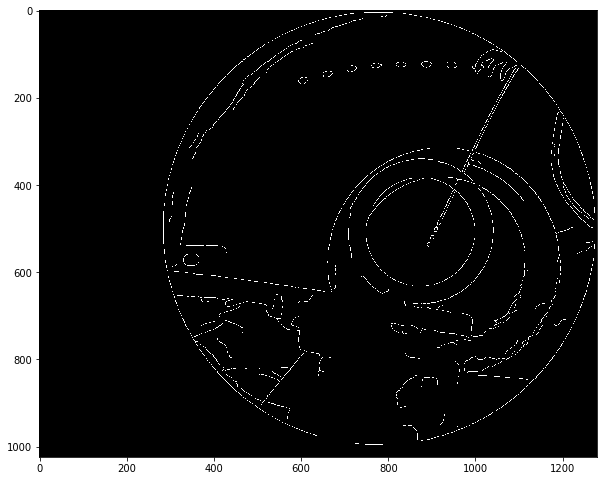

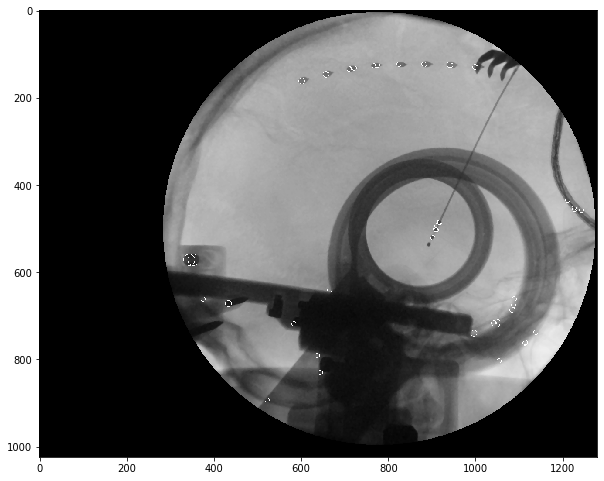

slope is  -0.10993305175462237
intercept is  735.6152486910005
r squared is  0.05569348726952727
r_squared :  0.05569348726952727
slope is  -0.06329725213014041
intercept is  183.8378338986644
r squared is  0.5464870464132906
r_squared :  0.5464870464132906
good cluster: 
 [[ 125  942]
 [ 130  999]
 [ 124  825]
 [ 124  883]
 [ 147  658]
 [ 135  712]
 [ 127  768]
 [ 135  711]
 [ 162  602]
 [ 133  723]
 [ 123  882]
 [ 125  941]
 [ 130 1000]
 [ 147  657]
 [ 126  776]]


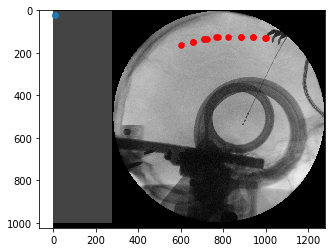

electrode_results for  Data/DBS_bG12_fluoro.tif
big_radius =  496
big_central_coordinate =  (500, 780)


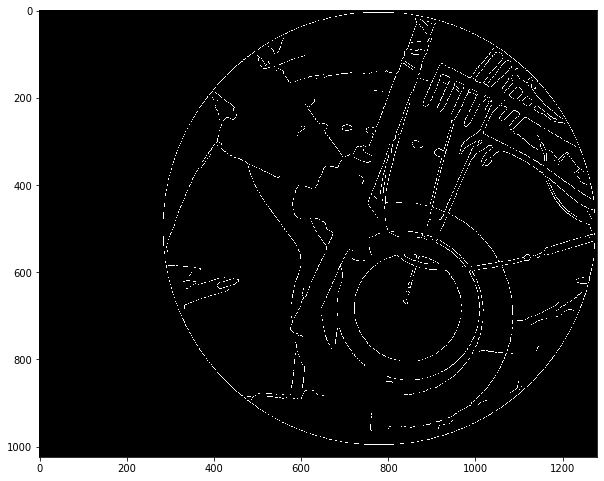

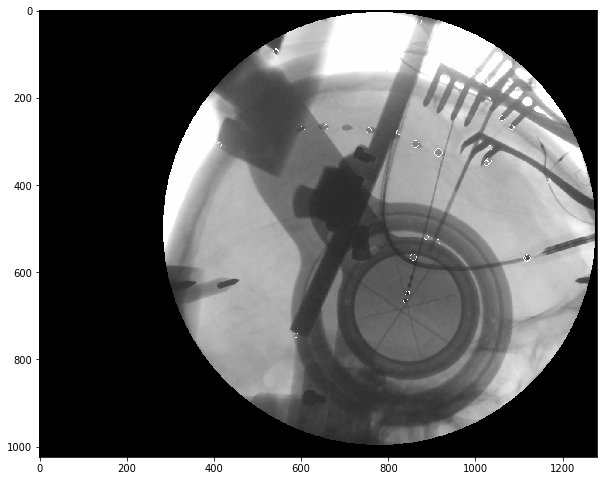

slope is  -0.29781838448982845
intercept is  874.7060034237031
r squared is  0.48875156084413734
r_squared :  0.48875156084413734
slope is  0.026853533941456578
intercept is  194.25038013439678
r squared is  0.003462066611166827
r_squared :  0.003462066611166827
good cluster: 
 [[ 567 1119]
 [ 666  841]
 [ 520  888]
 [ 648  846]
 [ 567 1121]
 [ 648  844]
 [ 745  589]
 [ 530  915]
 [ 566  858]
 [ 568 1119]]


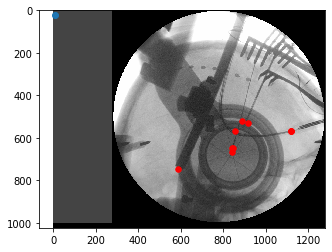

electrode_results for  Data/DBS_bG13_fluoro.tif
big_radius =  496
big_central_coordinate =  (500, 780)


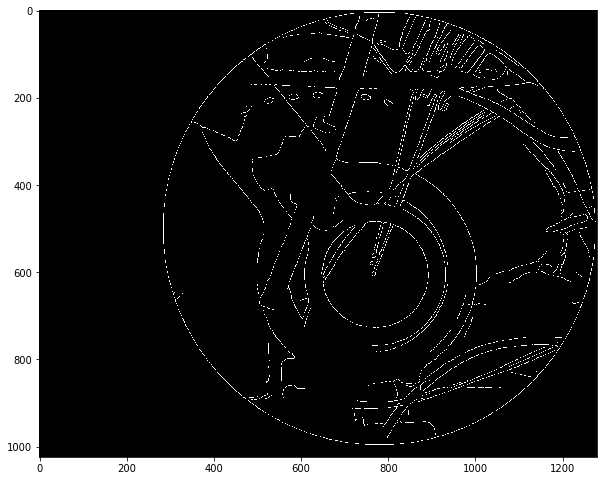

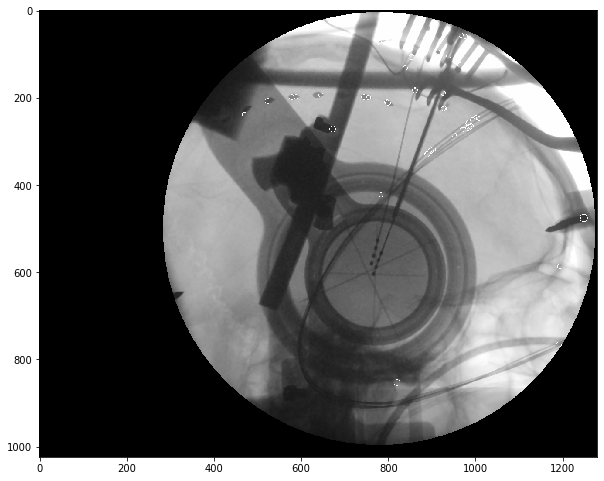

slope is  0.37443109970911026
intercept is  -13.181329194615216
r squared is  0.07361341888928442
r_squared :  0.07361341888928442
slope is  -0.2700395054743714
intercept is  375.0151765628103
r squared is  0.48233168879358973
r_squared :  0.48233168879358973
good cluster: 
 [[199 579]
 [105 939]
 [ 96 915]
 [210 797]
 [132 840]
 [ 57 968]
 [184 862]
 [183 862]
 [126 966]
 [208 524]
 [198 589]
 [ 60 977]
 [ 75 781]
 [190 927]
 [272 673]
 [199 745]
 [107 854]
 [198 588]
 [212 800]
 [200 755]
 [239 471]
 [194 646]]


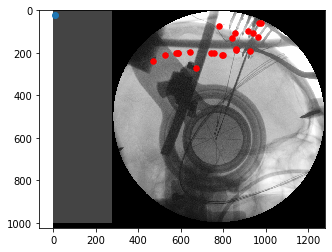

electrode_results for  Data/DBS_bG17_fluoro.tif
big_radius =  496
big_central_coordinate =  (500, 780)


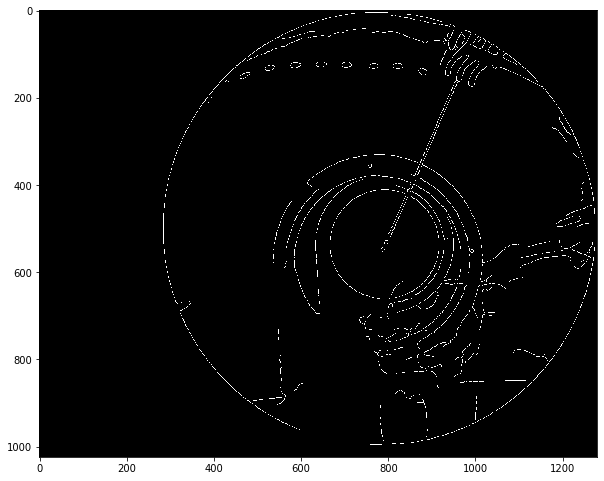

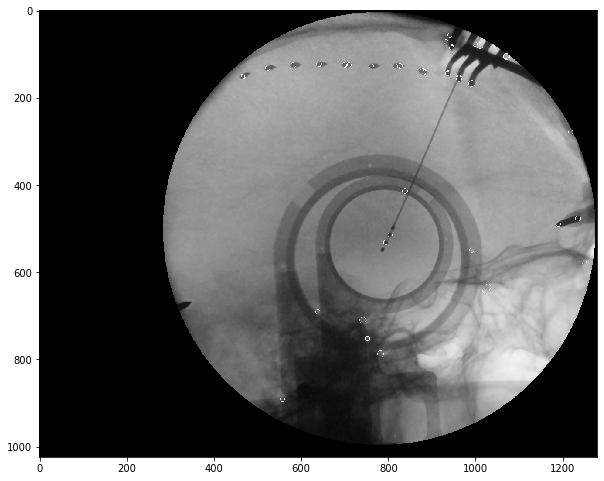

slope is  -0.4645551307127978
intercept is  1025.1654817176259
r squared is  0.45117639136719934
r_squared :  0.45117639136719934
slope is  -0.05354514664042745
intercept is  167.42389755765544
r squared is  0.1148311576683219
r_squared :  0.1148311576683219
good cluster: 
 [[ 710  742]
 [ 477 1236]
 [ 550  992]
 [ 577 1250]
 [ 691  639]
 [ 752  753]
 [ 634 1029]
 [ 787  783]
 [ 414  839]
 [ 891  558]
 [ 643 1022]
 [ 532  795]
 [ 515  805]
 [ 490 1191]
 [ 279 1219]]


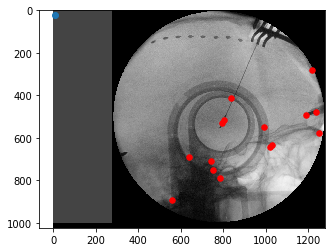

electrode_results for  Data/DBS_bG18_fluoro.tif
big_radius =  496
big_central_coordinate =  (500, 780)


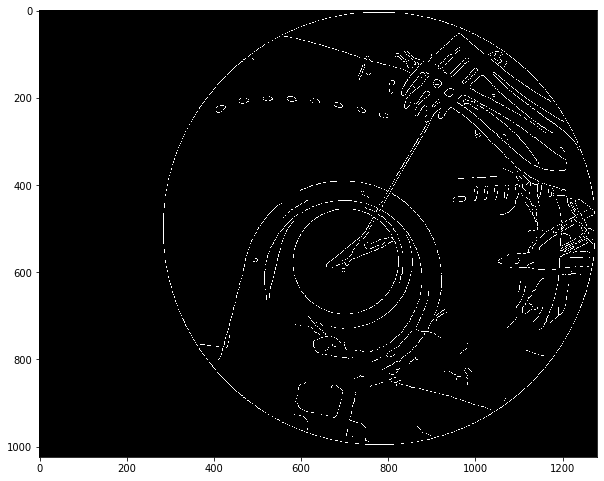

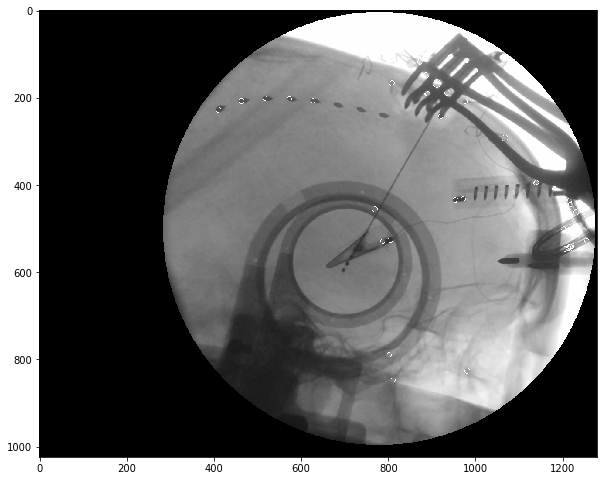

slope is  -0.8031479123523816
intercept is  1469.991413989478
r squared is  0.6500954373862915
r_squared :  0.6500954373862915
slope is  0.024789696657568524
intercept is  226.07267722883563
r squared is  0.0010545969835509307
r_squared :  0.0010545969835509307
good cluster: 
 [[ 409 1182]
 [ 847  812]
 [ 394 1141]
 [ 541 1220]
 [ 528 1256]
 [ 435 1217]
 [ 463 1232]
 [ 445 1219]
 [ 499 1202]
 [ 542 1218]
 [ 826  982]
 [ 484 1223]
 [ 547 1207]
 [ 544 1214]
 [ 543 1216]
 [ 539 1223]
 [ 395 1140]
 [ 546 1224]
 [ 789  803]]


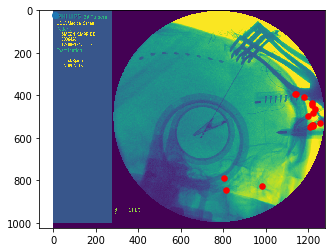

electrode_results for  Data/DBS_bG19_fluoro.tif
big_radius =  496
big_central_coordinate =  (500, 780)


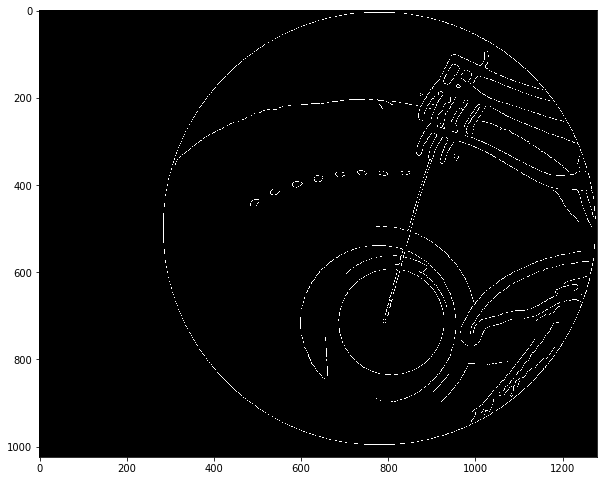

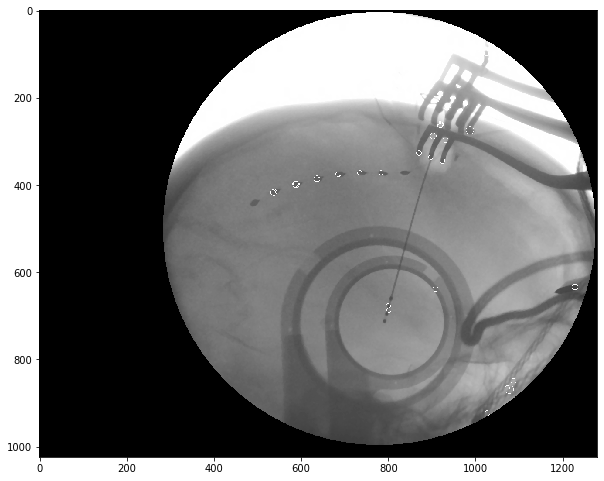

slope is  -1.0184942809373998
intercept is  1205.3719956169432
r squared is  0.4257832311546309
r_squared :  0.4257832311546309
slope is  0.6859573619211903
intercept is  -3.2816757481025434
r squared is  0.6266921117176861
r_squared :  0.6266921117176861
good cluster: 
 [[ 399  587]
 [ 376  686]
 [ 677  801]
 [ 386  637]
 [ 634 1230]
 [ 376  685]
 [ 923 1028]
 [ 386  636]
 [ 417  536]
 [ 417  538]
 [ 634 1229]
 [ 850 1088]
 [ 865 1074]
 [ 687  802]
 [ 372  784]
 [ 372  735]
 [ 868 1078]
 [ 399  590]
 [ 399  588]
 [ 638  909]]


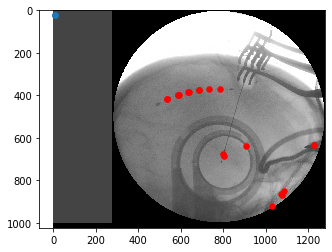

In [8]:
for input_path, output_path in zip(raw_patient, save_path):
    print("electrode_results for ", input_path)
    good_cluster = electrode_detection1.electrode_detection(input_path, output_path)
    im = plt.imread(input_path)
    implot = plt.imshow(im)
    # put a blue dot at (10, 20)
    plt.scatter([10], [20])
    # put a red dot, size 40, at 2 locations:
    plt.scatter(good_cluster[:,1], good_cluster[:,0], c='r', s=30)
    plt.show()

potential improvements:
1. [polynomial regression](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)
2. [linear regression]

***attempt to search for elipse***

In [13]:
len(hi)

3